# Node representation learning with Deep Graph Infomax and HinSAGE


This demo demonstrates how to perform unsupervised training of a GCN, GAT, APPNP, or GraphSAGE model using the Deep Graph Infomax algorithm (https://arxiv.org/pdf/1809.10341.pdf) on the GM12878_sample dataset. 

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

In [6]:
import networkx as nx
import numpy as np

from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    DirectedGraphSAGENodeGenerator,
    HinSAGENodeGenerator,
)
from stellargraph import StellarDiGraph
from stellargraph.layer import GCN, DeepGraphInfomax, DirectedGraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
if tf.test.gpu_device_name():
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

from pathlib import Path
from helper import Preprocess, Feature

Default GPU Device:/device:GPU:0


## Load graph and node features

In [ ]:
DATA_DIR = Path("../../data/")
FEATURE_DIR = Path("../../data/features/")
FEATURE_NAME = 'adjacentTFs'
MODEL_NAME='graphsage_128_128_relu_20_5_adjacentTF_1e-4'

data_processor = Preprocess()


In [3]:
df = data_processor.raw2train(DATA_DIR)

df

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (954968, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 390088
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------


,cell_type,source,target,type,weight
0,GM12878,ATF3_gm,SDF4,TSS,179.619
1,GM12878,ATF3_gm,B3GALT6,TSS,178.254
2,GM12878,ATF3_gm,SSU72,TSS,413
3,GM12878,ATF3_gm,AL645728.1,TSS,413
4,GM12878,ATF3_gm,CDK11A,TSS,160
...,...,...,...,...,...
786673,NA,ZYX,NEDD8,PPI,NA
786674,NA,ZYX,UBC,PPI,NA
786675,NA,ZYX,VASP,PPI,NA
786676,NA,ZZEF1,UBC,PPI,NA


## Feature extration
### Adjacent TFs


In [4]:
try:
    feature_df = pd.read_csv(FEATURE_DIR / f'{FEATURE_NAME}.csv', index_col=0)
    print('Read features from existing feature file')
except:
    print('Generating features...')
    common_tf = set(data_processor.raw2tf(DATA_DIR, option='intersection')['tf'])
    feature_df = Feature().adjacentTFs(df, common_tf)

Read features from existing feature file


## Read graph

In [5]:
df['edge_type'] = df['type'].map(lambda x: 1 if x == 'TSS' else 0)


G = StellarDiGraph(edges=df[['source', 'target', 'edge_type']], edge_type_column='edge_type', nodes=feature_df)
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 18573, Edges: 786678

 Node types:
  default: [18573]
    Features: float32 vector, length 138
    Edge types: default-0->default, default-1->default

 Edge types:
    default-1->default: [744602]
        Weights: all 1 (default)
        Features: none
    default-0->default: [42076]
        Weights: all 1 (default)
        Features: none


## Data Generators

Now we create the data generators using `CorruptedGenerator`. `CorruptedGenerator` returns shuffled node features along with the regular node features and we train our model to discriminate between the two. 

Note that:

- We typically pass all nodes to `corrupted_generator.flow` because this is an unsupervised task
- We don't pass `targets` to `corrupted_generator.flow` because these are binary labels (true nodes, false nodes) that are created by `CorruptedGenerator`

In [18]:
# HinSAGE model 
graphsage_generator = DirectedGraphSAGENodeGenerator(
    G, batch_size=50, in_samples=[20, 5], out_samples=[20, 5]
)

graphsage_model = DirectedGraphSAGE(
    layer_sizes=[128, 128], activations=["relu", "relu"], generator=graphsage_generator
)


corrupted_generator = CorruptedGenerator(graphsage_generator)
gen = corrupted_generator.flow(G.nodes())

## Model Creation and Training

We create and train our `DeepGraphInfomax` model. Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [19]:
import tensorflow as tf

In [20]:
infomax = DeepGraphInfomax(graphsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, 
              optimizer=Adam(lr=1e-4),
              )

In [22]:
epochs = 500

In [23]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)

history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[])
# model.save(f'./cps/{MODEL_NAME}.h5')

  ...
    to  
  ['...']
Train for 372 steps
Epoch 1/500
372/372 [==============================] - 46s 124ms/step - loss: 0.1159
Epoch 2/500
372/372 [==============================] - 44s 119ms/step - loss: 0.0078
Epoch 3/500
372/372 [==============================] - 45s 120ms/step - loss: 0.0040
Epoch 4/500
372/372 [==============================] - 44s 118ms/step - loss: 0.0026
Epoch 5/500
372/372 [==============================] - 44s 118ms/step - loss: 0.0022
Epoch 6/500
372/372 [==============================] - 44s 118ms/step - loss: 0.0014
Epoch 7/500
372/372 [==============================] - 44s 119ms/step - loss: 0.0011
Epoch 8/500
372/372 [==============================] - 44s 119ms/step - loss: 9.6661e-04
Epoch 9/500
372/372 [==============================] - 44s 120ms/step - loss: 8.3660e-04
Epoch 10/500
372/372 [==============================] - 45s 120ms/step - loss: 4.8670e-04
Epoch 11/500
372/372 [==============================] - 45s 120ms/step - loss: 3.9003e-04
Ep

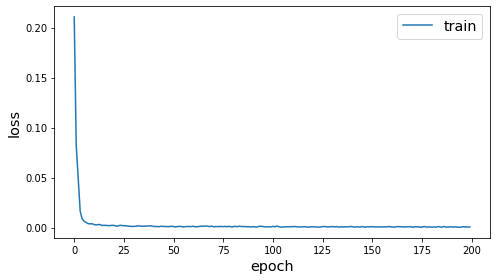

In [12]:
plot_history(history)

## Extracting Embeddings

Since we've already trained the weights of our base model - HinSAGE in this example - we can simply use `base_model.in_out_tensors` to obtain the trained node embedding model. 

In [13]:
x_emb_in, x_emb_out = graphsage_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
# x_out = tf.squeeze(x_emb_out, axis=0)
# emb_model = Model(inputs=x_emb_in, outputs=x_out)

# not using full batch models
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [14]:
all_embeddings = emb_model.predict(graphsage_generator.flow(G.nodes()))

trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())


In [15]:
def geneType(name):
    if name[-2:] == '_k':
        return 1
    elif name[-3:] == '_gm':
        return 2
    else:
        return 0

emb_transformed['type'] = emb_transformed.index.map(geneType)

In [16]:
emb = pd.DataFrame(all_embeddings, index=G.nodes())
emb['type'] = emb.index.map(geneType)
emb[emb.index == 'ATF3_gm']
# emb.to_csv(f'./emb/{MODEL_NAME}.csv', index=True, header=True)

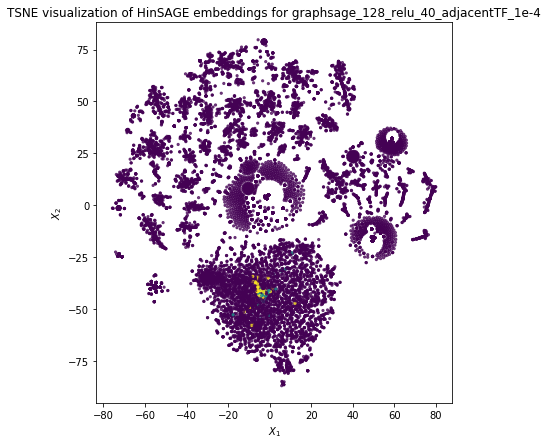

In [17]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
#     cmap="Paired",
    alpha=alpha,
    s=5
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings for {MODEL_NAME}")

# plt.savefig(f'./img/full/{MODEL_NAME}.png', dpi=150)
plt.show()

